In [22]:
# 通用导入
import sys
import importlib
from pathlib import Path
import warnings
import tqdm

# 设定项目根目录（notebooks/phase1_data_diagnostics 下一级为 notebooks，再上一级为项目根）
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from scipy import stats
except Exception:
    stats = None

try:
    from tqdm.notebook import tqdm as _notebook_tqdm
    if importlib.util.find_spec('ipywidgets') is not None:
        tqdm = _notebook_tqdm
    else:
        from tqdm import tqdm
except Exception:
    from tqdm import tqdm

from src.utils.config import load_config, get_data_path
from src.utils.io import load_parquet

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

print(f"项目根目录: {project_root}")

项目根目录: g:\理财\Quant_A_share_LongTerm


In [23]:
# 参数配置：采样规模与阈值
SAMPLE_N = 2000  # 日线采样股票数
RECENT_YEARS = 3  # 缺口率近几年窗口
TURNOVER_LOW_Q = 0.10  # 换手率低分位阈值
AMOUNT_LOW_Q = 0.10    # 成交额低分位阈值
LOW_LIQ_THRESHOLD = 0.30  # 低流动性比例触发阈值
LOW_LIQ_MIN_DAYS = 60  # 计算低流动性比例所需最少交易日（过滤超短历史/新股）
EXPORT_FLAGGED_PATH = project_root / 'reports' / 'flagged_daily_quality.csv'
print(f'采样规模: {SAMPLE_N}, 近{RECENT_YEARS}年缺口窗口, 换手率低分位: {TURNOVER_LOW_Q}, 成交额低分位: {AMOUNT_LOW_Q}, 低流动性阈值: {LOW_LIQ_THRESHOLD}, 低流动性最少天数: {LOW_LIQ_MIN_DAYS}')


采样规模: 2000, 近3年缺口窗口, 换手率低分位: 0.1, 成交额低分位: 0.1, 低流动性阈值: 0.3, 低流动性最少天数: 60


# 模块2 日线行情分析概览
- 覆盖与缺口：记录数/覆盖天数/缺口率，按上市年份、市场对比
- 价格与波动：收益分布、QQ 图、滚动波动率、IQR 异常值
- 流动性：成交额/换手率分布，行业×年份热力图
- 缺失与异常：核心字段空/零/负值率，涨跌幅一致性，停牌标记
- 复权一致性：收盘价 vs 前复权价
- 稳定性：按年份缺失率、波动率、极值比例
- 相关性：换手率与波动率关系
- 过滤与标注：高缺口/高缺失/低流动性清单

In [24]:
# 覆盖度与缺口：采样 SAMPLE_N 只股票，统计覆盖/缺口/空值
raw_path = get_data_path('raw')
meta_path = get_data_path('meta')
daily_dir = raw_path / 'market' / 'daily'
daily_basic_dir = raw_path / 'market' / 'daily_basic'

# 元数据：交易日历与股票信息
trade_cal = load_parquet(meta_path / 'trade_cal.parquet')
trade_days = pd.to_datetime(trade_cal[trade_cal['is_open'] == 1]['cal_date'])
trade_max = trade_days.max()
recent_cutoff = trade_max - pd.Timedelta(days=365 * RECENT_YEARS)
stock_basic = load_parquet(meta_path / 'stock_basic.parquet')
stock_basic['list_date'] = pd.to_datetime(stock_basic['list_date'], errors='coerce')
stock_basic['list_year'] = stock_basic['list_date'].dt.year
stock_basic['ts_code_norm'] = stock_basic['ts_code'].str.replace('.', '_', regex=False)
stock_basic['market'] = stock_basic['market'].fillna('未知')
stock_basic['industry'] = stock_basic['industry'].fillna('未知')

def infer_market_from_code(code: str):
    if isinstance(code, str):
        if code.endswith(('.SH', '_SH')):
            return '上交所'
        if code.endswith(('.SZ', '_SZ')):
            return '深交所'
        if code.endswith(('.BJ', '_BJ')):
            return '北交所'
    return '未知'

# 采样日线文件（分层抽样，覆盖所有 market）
daily_files_all = sorted(daily_dir.glob('*.parquet'))
df_files = pd.DataFrame({'path': daily_files_all})
df_files['ts_code_norm'] = df_files['path'].map(lambda p: p.stem)
df_files['ts_code'] = df_files['ts_code_norm'].str.replace('_', '.', regex=False)
df_files = df_files.merge(stock_basic[['ts_code', 'market']], on='ts_code', how='left')
df_files['market'] = df_files['market'].fillna(df_files['ts_code'].apply(infer_market_from_code))

if SAMPLE_N and SAMPLE_N < len(df_files):
    market_counts = df_files['market'].value_counts()
    n_market = len(market_counts)
    min_per_market = max(10, SAMPLE_N // max(1, n_market))
    sampled = []
    for mkt, grp in df_files.groupby('market'):
        take = min(len(grp), min_per_market)
        sampled.append(grp.sample(n=take, random_state=42))
    remaining = SAMPLE_N - sum(len(s) for s in sampled)
    used_paths = pd.concat(sampled)['path'] if sampled else pd.Series(dtype='object')
    if remaining > 0:
        remaining_pool = df_files[~df_files['path'].isin(used_paths)]
        if remaining_pool.empty:
            remaining_pool = df_files
        sampled.append(remaining_pool.sample(n=min(remaining, len(remaining_pool)), random_state=42))
    df_files_sample = pd.concat(sampled).drop_duplicates('path').sample(frac=1, random_state=42).head(SAMPLE_N)
else:
    df_files_sample = df_files

print('采样 market 分布:')
print(df_files_sample['market'].value_counts())

daily_files = df_files_sample['path'].tolist()
daily_files_map = {f.stem: f for f in daily_files}

core_fields = ['open', 'high', 'low', 'close', 'vol', 'amount']
daily_stats = []
for f in tqdm(daily_files, desc='采样日线覆盖'):
    df = load_parquet(f)
    if len(df) == 0:
        continue
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    covered = df['trade_date']
    coverage_days = (covered.max() - covered.min()).days + 1
    # 使用 DatetimeIndex 求差集，避免 Series 没有 difference 方法
    missing = pd.Index(trade_days[(trade_days >= covered.min()) & (trade_days <= covered.max())]).difference(pd.Index(covered))
    # 近 RECENT_YEARS 年缺口率
    recent_start = max(covered.min(), recent_cutoff)
    trade_recent = pd.Index(trade_days[(trade_days >= recent_start) & (trade_days <= covered.max())])
    covered_recent = pd.Index(covered[(covered >= recent_start) & (covered <= covered.max())])
    missing_recent = trade_recent.difference(covered_recent)
    coverage_recent_days = len(trade_recent)
    gap_recent_pct = len(missing_recent) / coverage_recent_days * 100 if coverage_recent_days > 0 else np.nan

    existing_fields = [c for c in core_fields if c in df.columns]
    null_rate = df[existing_fields].isnull().mean().mean() * 100 if existing_fields else np.nan
    zero_rate = (df[existing_fields] == 0).mean().mean() * 100 if existing_fields else np.nan
    daily_stats.append({
        'ts_code': f.stem,
        'ts_code_norm': f.stem,
        '记录数': len(df),
        '开始日期': covered.min(),
        '结束日期': covered.max(),
        '覆盖天数': coverage_days,
        '缺口天数': len(missing),
        '缺口率': len(missing) / coverage_days * 100,
        '近3年覆盖天数': coverage_recent_days,
        '近3年缺口率': gap_recent_pct,
        '核心字段空值率': null_rate,
        '核心字段零值率': zero_rate
    })

df_daily_stats = pd.DataFrame(daily_stats)

# 用 stock_basic 进行信息补全；再用代码后缀兜底推断市场
df_daily_stats = df_daily_stats.merge(stock_basic[['ts_code_norm', 'market', 'industry', 'list_year']], on='ts_code_norm', how='left')
df_daily_stats['market'] = df_daily_stats['market'].fillna(df_daily_stats['ts_code'].apply(infer_market_from_code))
df_daily_stats['industry'] = df_daily_stats['industry'].fillna('未知')

df_daily_stats.head()


采样 market 分布:
market
主板     656
创业板    546
科创板    511
北交所    287
Name: count, dtype: int64


采样日线覆盖: 100%|██████████| 2000/2000 [00:20<00:00, 97.53it/s] 


,ts_code,ts_code_norm,记录数,开始日期,结束日期,覆盖天数,缺口天数,缺口率,近3年覆盖天数,近3年缺口率,核心字段空值率,核心字段零值率,market,industry,list_year
0,600768_SH,600768_SH,3569,2010-01-04,2025-12-26,5836,314,5.380398,728,0.0,0.0,0.0,主板,铝,1996
1,603276_SH,603276_SH,546,2023-09-25,2025-12-26,824,0,0.000000,546,0.0,0.0,0.0,主板,化工原料,2023
2,688603_SH,688603_SH,601,2023-07-10,2025-12-26,901,0,0.000000,601,0.0,0.0,0.0,科创板,化工原料,2023
3,300808_SZ,300808_SZ,1475,2019-11-29,2025-12-26,2220,0,0.000000,728,0.0,0.0,0.0,创业板,家用电器,2019
4,688737_SH,688737_SH,1017,2021-10-22,2025-12-26,1527,0,0.000000,728,0.0,0.0,0.0,科创板,汽车配件,2021


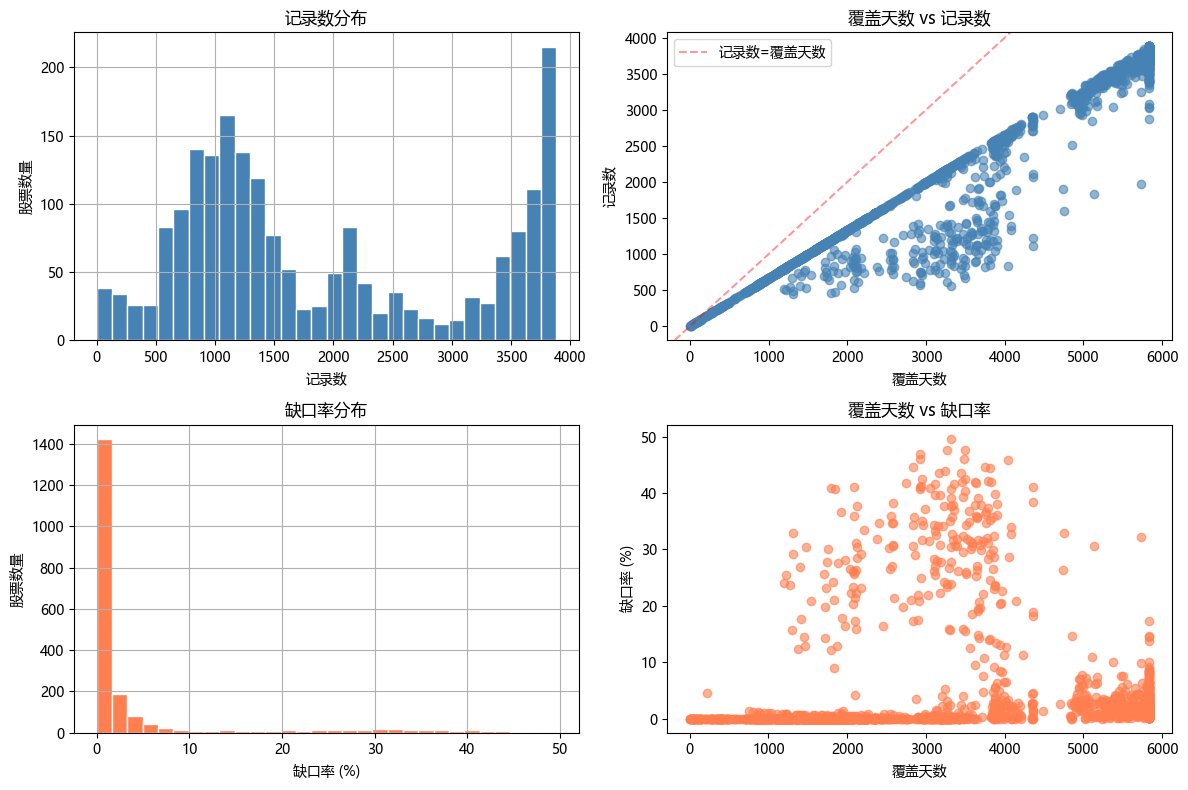

In [25]:
# 覆盖度与缺口可视化
if not df_daily_stats.empty:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # 记录数分布
    df_daily_stats['记录数'].hist(bins=30, ax=axes[0, 0], color='steelblue', edgecolor='white')
    axes[0, 0].set_title('记录数分布')
    axes[0, 0].set_xlabel('记录数')
    axes[0, 0].set_ylabel('股票数量')

    # 覆盖天数 vs 记录数
    axes[0, 1].scatter(df_daily_stats['覆盖天数'], df_daily_stats['记录数'], alpha=0.6, color='steelblue')
    axes[0, 1].axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.4, label='记录数=覆盖天数')
    axes[0, 1].set_xlabel('覆盖天数')
    axes[0, 1].set_ylabel('记录数')
    axes[0, 1].set_title('覆盖天数 vs 记录数')
    axes[0, 1].legend()

    # 缺口率分布
    df_daily_stats['缺口率'].hist(bins=30, ax=axes[1, 0], color='coral', edgecolor='white')
    axes[1, 0].set_title('缺口率分布')
    axes[1, 0].set_xlabel('缺口率 (%)')
    axes[1, 0].set_ylabel('股票数量')

    # 覆盖天数 vs 缺口率
    axes[1, 1].scatter(df_daily_stats['覆盖天数'], df_daily_stats['缺口率'], alpha=0.6, color='coral')
    axes[1, 1].set_xlabel('覆盖天数')
    axes[1, 1].set_ylabel('缺口率 (%)')
    axes[1, 1].set_title('覆盖天数 vs 缺口率')

    plt.tight_layout()
    plt.show()

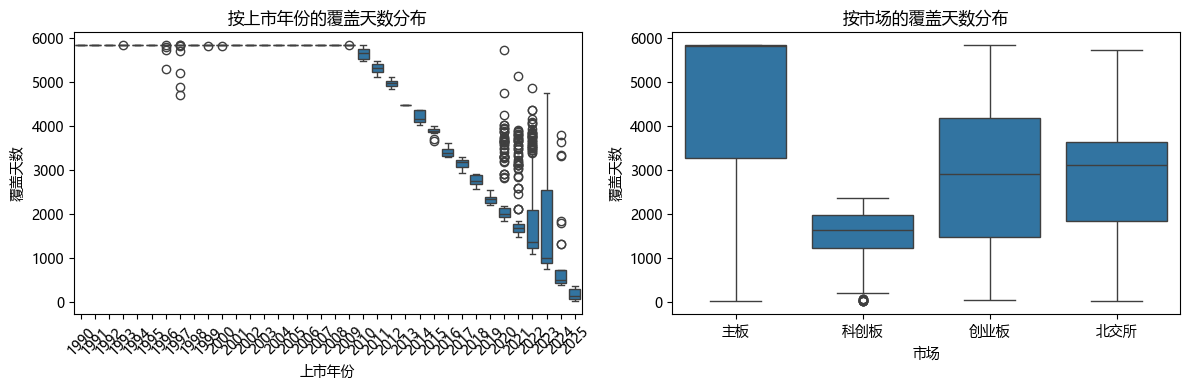

In [26]:
# 分组覆盖度对比：上市年份与市场
if not df_daily_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    df_year = df_daily_stats.dropna(subset=['list_year'])
    if not df_year.empty:
        sns.boxplot(data=df_year, x='list_year', y='覆盖天数', ax=axes[0])
        axes[0].set_title('按上市年份的覆盖天数分布')
        axes[0].set_xlabel('上市年份')
        axes[0].set_ylabel('覆盖天数')
        axes[0].tick_params(axis='x', rotation=45)
    else:
        axes[0].text(0.5, 0.5, '无上市年份数据', ha='center')
        axes[0].axis('off')
    
    df_market = df_daily_stats.dropna(subset=['market'])
    if not df_market.empty and df_market['market'].nunique() > 0:
        sns.boxplot(data=df_market, x='market', y='覆盖天数', ax=axes[1])
        axes[1].set_title('按市场的覆盖天数分布')
        axes[1].set_xlabel('市场')
        axes[1].set_ylabel('覆盖天数')
    else:
        axes[1].text(0.5, 0.5, '无市场分组数据', ha='center')
        axes[1].axis('off')
    plt.tight_layout()
    plt.show()

## 2.2 价格与波动
- 对数收益分布（直方图、QQ 图）
- 滚动波动率（示例股票或截面均值）
- 极值检测：涨跌幅与价格差分一致性

示例股票: 603167_SH
记录数: 3232 覆盖: 2012-09-06 至 2025-12-26
对数收益统计: {'mean': -6.735733810173128e-05, 'std': 0.024847487210438408, 'skew': -0.3926309897325528, 'kurt': 4.7457220278050585}
IQR 异常值数量: 92 (2.85%)


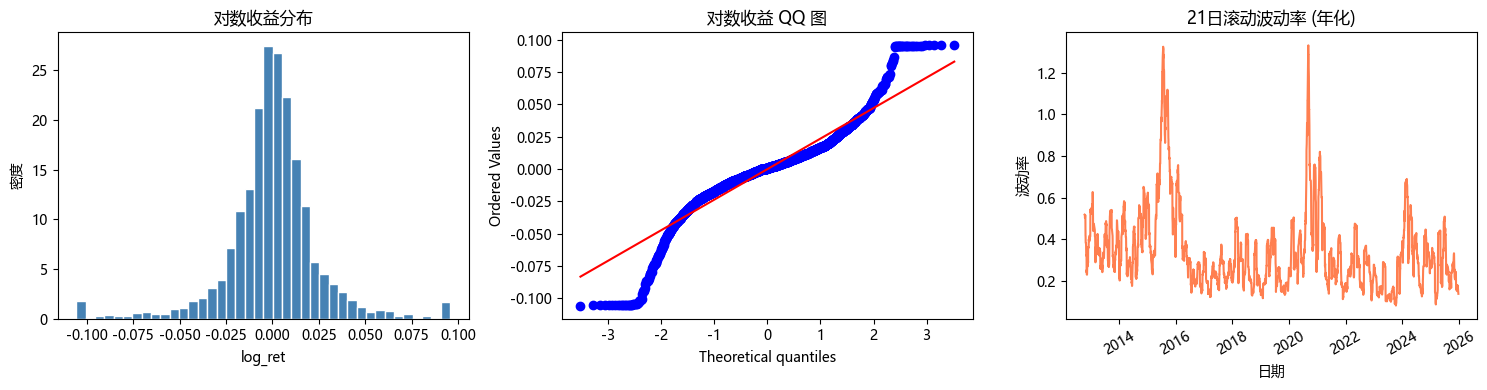

In [27]:
# 价格与波动：对数收益分布、极值、滚动波动率
if df_daily_stats.empty:
    raise ValueError('df_daily_stats 为空，无法进行价格与波动分析')

# 选覆盖好且缺口低的股票
sample_code = df_daily_stats.sort_values(['缺口率', '覆盖天数'], ascending=[True, False]).iloc[0]['ts_code']
sample_path = daily_files_map.get(sample_code, daily_dir / f"{sample_code}.parquet")
sample_df = load_parquet(sample_path).copy()
sample_df['trade_date'] = pd.to_datetime(sample_df['trade_date'])
sample_df = sample_df.sort_values('trade_date')
sample_df['log_ret'] = np.log(sample_df['close']).diff()

def outlier_iqr(series):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 3 * iqr, q3 + 3 * iqr
    mask = (series < lower) | (series > upper)
    return mask.sum(), lower, upper

log_ret = sample_df['log_ret'].dropna()
iqr_n, iqr_lower, iqr_upper = outlier_iqr(log_ret)
desc = log_ret.agg(['mean', 'std', 'skew', 'kurt'])

start_date = sample_df['trade_date'].min()
end_date = sample_df['trade_date'].max()
print(f"示例股票: {sample_code}")
print(f"记录数: {len(sample_df)} 覆盖: {start_date.date()} 至 {end_date.date()}")
print(f"对数收益统计: {desc.to_dict()}")
print(f"IQR 异常值数量: {iqr_n} ({iqr_n / len(log_ret) * 100:.2f}%)")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(log_ret, bins=40, color='steelblue', edgecolor='white', density=True)
axes[0].set_title('对数收益分布')
axes[0].set_xlabel('log_ret')
axes[0].set_ylabel('密度')

if stats is not None:
    stats.probplot(log_ret, dist='norm', plot=axes[1])
    axes[1].set_title('对数收益 QQ 图')
else:
    axes[1].text(0.5, 0.5, 'SciPy 不可用，跳过 QQ 图', ha='center')
    axes[1].set_axis_off()

sample_df['rolling_vol'] = log_ret.rolling(21).std() * np.sqrt(252)
axes[2].plot(sample_df['trade_date'], sample_df['rolling_vol'], color='coral')
axes[2].set_title('21日滚动波动率 (年化)')
axes[2].set_xlabel('日期')
axes[2].set_ylabel('波动率')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

## 2.3 流动性与成交结构
- 成交额/换手率分布，按市值/行业分层
- 尾部低流动性比例，年份维度演变

流动性采样: 100%|██████████| 2000/2000 [00:36<00:00, 54.53it/s]


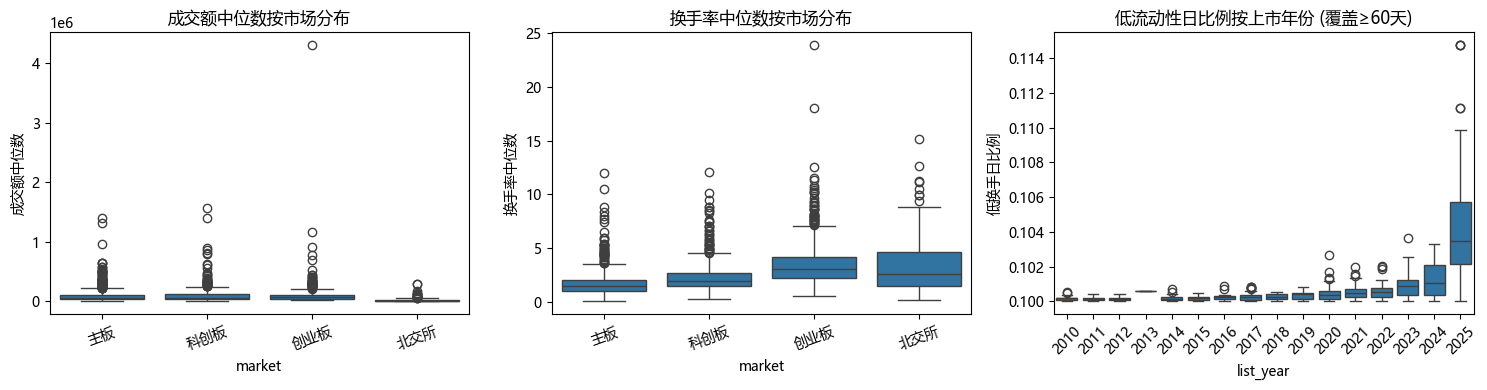

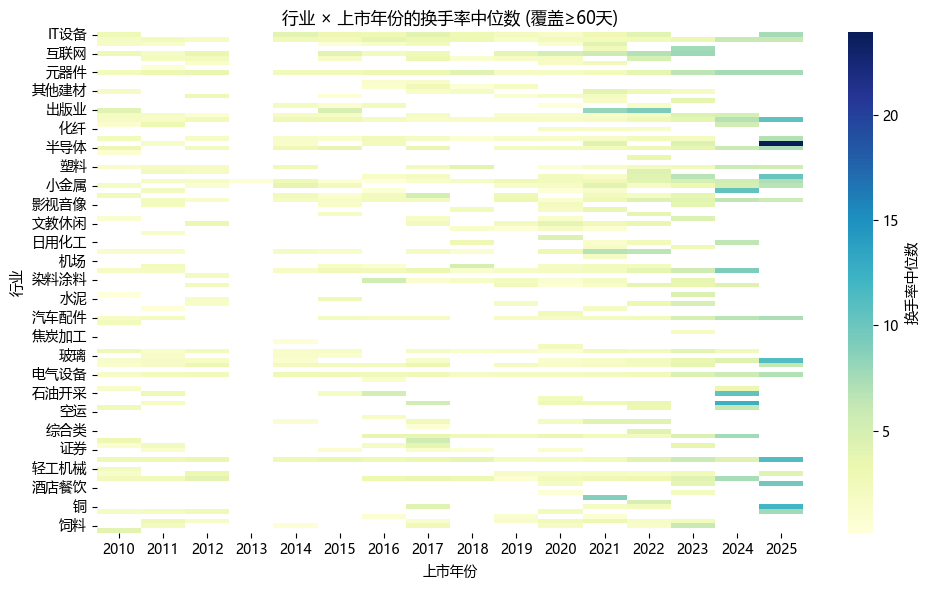

df_liq 预览:


,ts_code,trade_start_year,成交额中位数,成交量中位数,换手率中位数,低换手日比例,低成交额日比例,industry,market,list_year,ts_code_norm,覆盖天数
0,600768.SH,2010,22053.1610,22341.01,1.7180,0.100028,0.100028,铝,主板,1996,600768_SH,5836
1,603276.SH,2023,40796.2825,24648.18,3.9843,0.100733,0.100733,化工原料,主板,2023,603276_SH,824
2,688603.SH,2023,54565.4590,8590.09,4.0551,0.101498,0.101498,化工原料,科创板,2023,688603_SH,901
3,300808.SZ,2019,35242.6960,19965.00,2.8607,0.100339,0.100339,家用电器,创业板,2019,300808_SZ,2220
4,688737.SH,2021,28107.2970,10643.38,1.8300,0.100295,0.100295,汽车配件,科创板,2021,688737_SH,1527


In [28]:
# 成交与流动性：成交额/换手率分布与热力图

if df_daily_stats.empty:
    raise ValueError('df_daily_stats 为空，无法进行流动性分析')

# 统一代码规范，确保能对上 stock_basic
normalize = lambda s: s.replace('.', '_') if isinstance(s, str) else s
restore_dot = lambda s: s.replace('_', '.') if isinstance(s, str) else s

liq_records = []
turnover_candidates = ['turnover_rate', 'turnover_rate_f', 'turnover_rate5', 'turnover_rate20']
for code, path in tqdm(daily_files_map.items(), desc='流动性采样'):
    db_path = daily_basic_dir / f"{code}.parquet"
    if not db_path.exists():
        continue
    df = load_parquet(path)
    db = load_parquet(db_path)
    if len(df) == 0 or len(db) == 0:
        continue
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    db['trade_date'] = pd.to_datetime(db['trade_date'])
    merged = df.merge(db, on=['ts_code', 'trade_date'], how='left')
    if 'amount' not in merged or 'vol' not in merged:
        continue

    # 选择可用的换手率列（大小写兼容）；若缺失则用成交额作为低流动性代理
    cols_lower = {c.lower(): c for c in merged.columns}
    turnover_col = None
    for cand in turnover_candidates:
        if cand in cols_lower:
            turnover_col = cols_lower[cand]
            break
    turnover = pd.to_numeric(merged[turnover_col], errors='coerce').dropna() if turnover_col else pd.Series(dtype=float)
    turnover_median = turnover.median() if len(turnover) else np.nan
    low_turnover_ratio = (turnover <= turnover.quantile(TURNOVER_LOW_Q)).mean() if len(turnover) >= LOW_LIQ_MIN_DAYS else np.nan

    amt = pd.to_numeric(merged['amount'], errors='coerce').dropna()
    low_amount_ratio = (amt <= amt.quantile(AMOUNT_LOW_Q)).mean() if len(amt) >= LOW_LIQ_MIN_DAYS else np.nan

    ts_norm = normalize(code)
    ts_dot = restore_dot(code)
    liq_records.append({
        # ts_code 与 df_daily_stats 对齐（下划线格式）；同时保留点格式
        'ts_code': ts_dot,
        'ts_code_norm': ts_norm,
        'trade_start_year': df['trade_date'].min().year,
        '成交额中位数': merged['amount'].median(),
        '成交量中位数': merged['vol'].median(),
        '换手率中位数': turnover_median,
        '低换手日比例': low_turnover_ratio,
        '低成交额日比例': low_amount_ratio
    })

df_liq = pd.DataFrame(liq_records)

# 对齐 meta 信息（先用 ts_code 直接匹配，兜底再用 ts_code_norm），统一列名
stock_basic['ts_code_norm'] = normalize(stock_basic['ts_code'])
df_liq = df_liq.merge(
    stock_basic[['ts_code', 'ts_code_norm', 'industry', 'market', 'list_year']],
    on='ts_code', how='left', suffixes=('_liq', '_sb')
)
if 'ts_code_norm_liq' in df_liq and 'ts_code_norm_sb' in df_liq:
    df_liq['ts_code_norm'] = df_liq['ts_code_norm_liq'].combine_first(df_liq['ts_code_norm_sb'])
    df_liq.drop(columns=['ts_code_norm_liq', 'ts_code_norm_sb'], inplace=True)

# 补充 coverage 天数便于过滤超短历史
df_liq = df_liq.merge(df_daily_stats[['ts_code_norm', '覆盖天数']], on='ts_code_norm', how='left')

# 兜底匹配缺失的行业/市场/年份
df_liq['market'] = df_liq['market'].fillna(df_liq['ts_code'].apply(infer_market_from_code))
df_liq['industry'] = df_liq['industry'].fillna('未知')
df_liq['list_year'] = pd.to_numeric(df_liq['list_year'], errors='coerce')
if 'trade_start_year' in df_liq:
    df_liq['list_year'] = df_liq['list_year'].fillna(df_liq['trade_start_year'])

# 用采样覆盖的实际开始年限制年份，避免早于行情的数据
if not df_daily_stats.empty and '开始日期' in df_daily_stats:
    _min_start = pd.to_datetime(df_daily_stats['开始日期']).min()
    data_start_year = int(_min_start.year) if pd.notna(_min_start) else None
else:
    data_start_year = None

# 过滤绘图数据：覆盖天数不足 MIN_DAYS 的新股不参与分布，可避免 2025 年极短历史拉偏
if '覆盖天数' in df_liq:
    df_liq_plot = df_liq[df_liq['覆盖天数'] >= LOW_LIQ_MIN_DAYS].copy()
else:
    df_liq_plot = df_liq.copy()

if not df_liq_plot.empty:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    df_market = df_liq_plot.dropna(subset=['market'])
    if not df_market.empty and df_market['market'].nunique() > 0:
        sns.boxplot(data=df_market, x='market', y='成交额中位数', ax=axes[0])
        axes[0].set_title('成交额中位数按市场分布')
        axes[0].tick_params(axis='x', rotation=20)
    else:
        axes[0].text(0.5, 0.5, '无市场分组数据', ha='center')
        axes[0].axis('off')

    if not df_market.empty and df_market['market'].nunique() > 0:
        sns.boxplot(data=df_market, x='market', y='换手率中位数', ax=axes[1])
        axes[1].set_title('换手率中位数按市场分布')
        axes[1].tick_params(axis='x', rotation=20)
    else:
        axes[1].text(0.5, 0.5, '无市场分组数据', ha='center')
        axes[1].axis('off')

    df_year = df_liq_plot.dropna(subset=['list_year'])
    if data_start_year is not None:
        df_year = df_year[df_year['list_year'] >= data_start_year]
    if not df_year.empty and df_year['list_year'].nunique() > 0:
        sns.boxplot(data=df_year, x='list_year', y='低换手日比例', ax=axes[2])
        axes[2].set_title(f'低流动性日比例按上市年份 (覆盖≥{LOW_LIQ_MIN_DAYS}天)')
        axes[2].tick_params(axis='x', rotation=45)
    else:
        axes[2].text(0.5, 0.5, '无上市年份分组数据', ha='center')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 行业×年份流动性热力图（换手率中位数）
    pivot_liq = df_liq_plot.pivot_table(index='industry', columns='list_year', values='换手率中位数', aggfunc='median')
    pivot_liq = pivot_liq.dropna(how='all').dropna(axis=1, how='all')
    pivot_liq.columns = pd.to_numeric(pivot_liq.columns, errors='coerce')
    if data_start_year is not None:
        pivot_liq = pivot_liq.loc[:, pivot_liq.columns >= data_start_year]
    pivot_liq = pivot_liq[sorted(pivot_liq.columns)] if not pivot_liq.empty else pivot_liq
    if not pivot_liq.empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_liq, cmap='YlGnBu', annot=False, cbar_kws={'label': '换手率中位数'})
        plt.title(f'行业 × 上市年份的换手率中位数 (覆盖≥{LOW_LIQ_MIN_DAYS}天)')
        plt.xlabel('上市年份')
        plt.ylabel('行业')
        plt.tight_layout()
        plt.show()

print('df_liq 预览:')
df_liq.head()


In [29]:
# 调试：查看 df_liq 列
print('df_liq columns:', df_liq.columns.tolist())


df_liq columns: ['ts_code', 'trade_start_year', '成交额中位数', '成交量中位数', '换手率中位数', '低换手日比例', '低成交额日比例', 'industry', 'market', 'list_year', 'ts_code_norm', '覆盖天数']


In [30]:
# 诊断市场分层与上市年份异常
print('df_liq market 分布:')
print(df_liq['market'].value_counts(dropna=False).head(20))
print('\n覆盖统计中的 market 分布:')
print(df_daily_stats['market'].value_counts(dropna=False).head(20))

print('\n上市年份描述:')
print(df_liq['list_year'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print('\n上市年份计数(尾部年份):')
print(df_liq['list_year'].value_counts().sort_index().tail(12))

print('\n2025 年样本(若有):')
print(df_liq[df_liq['list_year'] == 2025][['ts_code', 'trade_start_year', 'list_year', 'market']].head(20))


df_liq market 分布:
market
主板     656
创业板    546
科创板    511
北交所    287
Name: count, dtype: int64

覆盖统计中的 market 分布:
market
主板     656
创业板    546
科创板    511
北交所    287
Name: count, dtype: int64

上市年份描述:
count    2000.000000
mean     2015.969000
std         8.418698
min      1990.000000
25%      2012.000000
50%      2020.000000
75%      2022.000000
90%      2023.000000
95%      2024.000000
99%      2025.000000
max      2025.000000
Name: list_year, dtype: float64

上市年份计数(尾部年份):
list_year
2014     39
2015     51
2016     57
2017    108
2018     29
2019     94
2020    231
2021    275
2022    273
2023    178
2024     53
2025     64
Name: count, dtype: int64

2025 年样本(若有):
       ts_code  trade_start_year  list_year market
23   920022.BJ              2025       2025    北交所
26   920005.BJ              2025       2025    北交所
73   920007.BJ              2025       2025    北交所
94   001285.SZ              2025       2025     主板
112  920056.BJ              2025       2025    北交所
135  920003.BJ       

In [31]:
# 深挖 2025 年样本的交易日期范围与上市日期
codes_2025 = df_liq[df_liq['list_year'] == 2025]['ts_code'].head(5)
for code_dot in codes_2025:
    code_norm = code_dot.replace('.', '_')
    path = daily_files_map.get(code_norm, daily_dir / f"{code_norm}.parquet")
    if not path.exists():
        print(f"{code_dot}: 未找到日线文件 ({path.name})")
        continue
    df_tmp = load_parquet(path)
    if df_tmp.empty:
        print(f"{code_dot}: 日线数据为空")
        continue
    df_tmp['trade_date'] = pd.to_datetime(df_tmp['trade_date'])
    print(f"{code_dot}: 交易区间 {df_tmp['trade_date'].min().date()} ~ {df_tmp['trade_date'].max().date()}，记录数 {len(df_tmp)}")
    sb_row = stock_basic[stock_basic['ts_code'] == code_dot]
    if not sb_row.empty:
        print(f"  stock_basic 上市日期: {sb_row['list_date'].iloc[0].date()}")
    else:
        print("  stock_basic 中未找到记录")


920022.BJ: 交易区间 2025-09-19 ~ 2025-12-26，记录数 65
  stock_basic 上市日期: 2025-09-19
920005.BJ: 交易区间 2025-07-31 ~ 2025-12-26，记录数 101
  stock_basic 上市日期: 2025-07-31
920007.BJ: 交易区间 2025-08-08 ~ 2025-12-26，记录数 95
  stock_basic 上市日期: 2025-08-08
001285.SZ: 交易区间 2025-09-30 ~ 2025-12-26，记录数 58
  stock_basic 上市日期: 2025-09-30
920056.BJ: 交易区间 2025-08-22 ~ 2025-12-26，记录数 85
  stock_basic 上市日期: 2025-08-22


In [32]:
# 检查日线文件命名是否带下划线
probe_codes = ['001221', '001233', '001280', '001285', '001325']
for c in probe_codes:
    matches = [k for k in daily_files_map.keys() if c in k]
    print(c, 'matches:', matches[:5])


001221 matches: []
001233 matches: []
001280 matches: []
001285 matches: ['001285_SZ']
001325 matches: ['001325_SZ']


## 2.4 异常与停牌
- 停牌日标记，缺口与停牌对比
- 涨跌幅跳变（除权除息日）核对

示例股票: 603167_SH
核心字段空值率(%)：
open      0.0
high      0.0
low       0.0
close     0.0
vol       0.0
amount    0.0
dtype: float64
核心字段零值率(%)：
open      0.0
high      0.0
low       0.0
close     0.0
vol       0.0
amount    0.0
dtype: float64
核心字段负值率(%)：
open      0.0
high      0.0
low       0.0
close     0.0
vol       0.0
amount    0.0
dtype: float64
涨跌幅 vs 价格差分的差异统计：
count    3231.000000
mean        0.014591
std         0.227715
min        -0.005036
1%         -0.004783
5%         -0.003845
50%         0.000000
95%         0.003932
99%         0.004846
max         5.488397
Name: diff_gap, dtype: float64


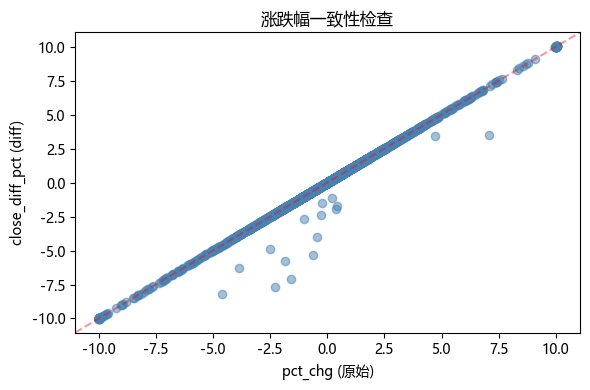

停牌/零成交日比例: 0.00%


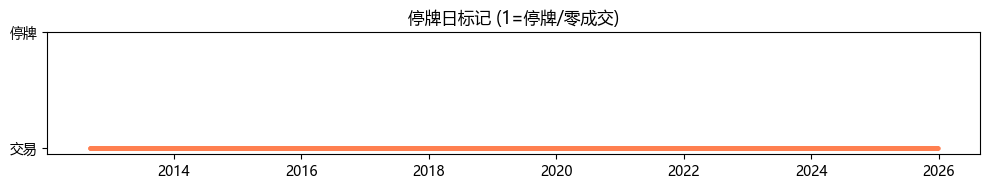

In [33]:
# 缺失与异常、涨跌幅一致性、停牌识别
if df_daily_stats.empty:
    raise ValueError('df_daily_stats 为空，无法进行异常检测')

sample_code = df_daily_stats.sort_values(['缺口率', '覆盖天数'], ascending=[True, False]).iloc[0]['ts_code']
df_s = load_parquet(daily_dir / f"{sample_code}.parquet").copy()
df_s = df_s.sort_values('trade_date')
df_s['trade_date'] = pd.to_datetime(df_s['trade_date'])

core_fields = ['open', 'high', 'low', 'close', 'vol', 'amount']
existing_fields = [c for c in core_fields if c in df_s.columns]
null_rates = df_s[existing_fields].isnull().mean() * 100 if existing_fields else pd.Series(dtype=float)
zero_rates = (df_s[existing_fields] == 0).mean() * 100 if existing_fields else pd.Series(dtype=float)
neg_rates = (df_s[existing_fields] < 0).mean() * 100 if existing_fields else pd.Series(dtype=float)

print(f"示例股票: {sample_code}")
print("核心字段空值率(%)：")
print(null_rates)
print("核心字段零值率(%)：")
print(zero_rates)
print("核心字段负值率(%)：")
print(neg_rates)

# 涨跌幅一致性检查
if 'pct_chg' in df_s.columns:
    df_s['close_diff_pct'] = df_s['close'].pct_change() * 100
    df_s['diff_gap'] = df_s['pct_chg'] - df_s['close_diff_pct']
    gap_stats = df_s['diff_gap'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
    print("涨跌幅 vs 价格差分的差异统计：")
    print(gap_stats)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(df_s['pct_chg'], df_s['close_diff_pct'], alpha=0.5, color='steelblue')
    ax.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.4)
    ax.set_xlabel('pct_chg (原始)')
    ax.set_ylabel('close_diff_pct (diff)')
    ax.set_title('涨跌幅一致性检查')
    plt.tight_layout()
    plt.show()

# 停牌日识别（基于成交量为0或缺失）
suspend_mask = (df_s['vol'].fillna(0) == 0) if 'vol' in df_s else pd.Series(dtype=bool)
suspend_ratio = suspend_mask.mean() if len(suspend_mask) else np.nan
print(f"停牌/零成交日比例: {suspend_ratio * 100:.2f}%")
if len(suspend_mask):
    plt.figure(figsize=(10, 2))
    plt.scatter(df_s['trade_date'], suspend_mask, s=5, color='coral')
    plt.title('停牌日标记 (1=停牌/零成交)')
    plt.yticks([0, 1], ['交易', '停牌'])
    plt.tight_layout()
    plt.show()

## 2.5 复权与价格一致性
- 比对前复权价格与原始收盘价
- 涨跌幅与价格差分的匹配程度

In [34]:
# 复权与价格一致性检查
db_path = daily_basic_dir / f"{sample_code}.parquet"
if db_path.exists():
    db_s = load_parquet(db_path).copy()
    db_s['trade_date'] = pd.to_datetime(db_s['trade_date'])
    merged = df_s.merge(db_s[['trade_date', 'ts_code', 'adj_factor']], on=['ts_code', 'trade_date'], how='left') if 'adj_factor' in db_s else df_s.copy()
    if 'adj_factor' in merged:
        merged['adj_close'] = merged['close'] * merged['adj_factor'] / merged['adj_factor'].iloc[0]
        plt.figure(figsize=(8, 4))
        plt.plot(merged['trade_date'], merged['close'], label='收盘价')
        plt.plot(merged['trade_date'], merged['adj_close'], label='前复权价', alpha=0.7)
        plt.legend()
        plt.title('收盘价 vs 前复权价')
        plt.xlabel('日期')
        plt.ylabel('价格')
        plt.tight_layout()
        plt.show()
    else:
        print('daily_basic 无 adj_factor，跳过复权一致性检查')
else:
    print('未找到对应 daily_basic 文件，跳过复权一致性检查')

daily_basic 无 adj_factor，跳过复权一致性检查


## 2.6 行情质量稳定性
- 按年份/季度观察缺失率、波动率、极值比例的演变

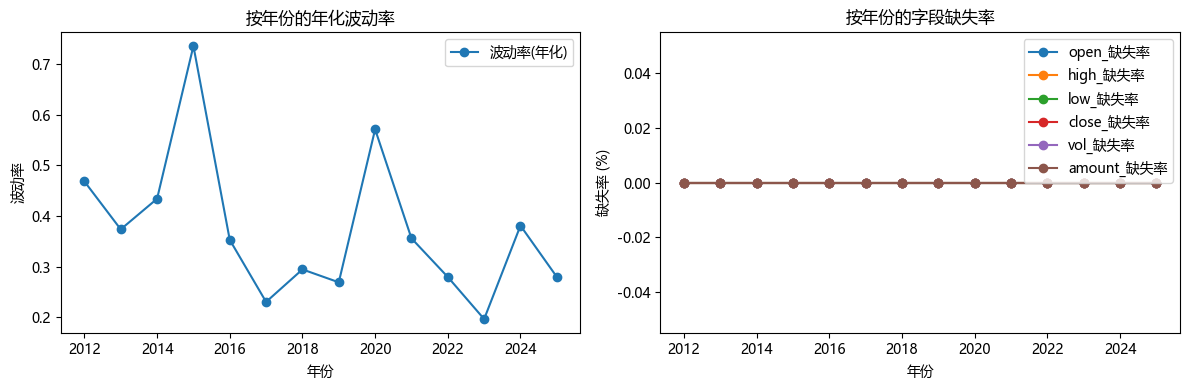

,year,open_缺失率,high_缺失率,low_缺失率,close_缺失率,vol_缺失率,amount_缺失率,波动率(年化),极值比例(|pct_chg|>11)
0,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.468105,0.0
1,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.373436,0.0
2,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.433853,0.0
3,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.735475,0.0
4,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.352691,0.0
5,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.230171,0.0
6,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.294352,0.0
7,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.268899,0.0
8,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.570905,0.0
9,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.355718,0.0


In [35]:
# 行情质量稳定性：按年份的缺失率与波动率演变
core_fields = ['open', 'high', 'low', 'close', 'vol', 'amount']
existing_fields = [c for c in core_fields if c in df_s.columns]
df_yearly = df_s.copy()
df_yearly['year'] = df_yearly['trade_date'].dt.year
year_stats = []
for year, g in df_yearly.groupby('year'):
    stats_row = {'year': year}
    for col in existing_fields:
        stats_row[f'{col}_缺失率'] = g[col].isnull().mean() * 100
    g['log_ret'] = np.log(g['close']).diff()
    stats_row['波动率(年化)'] = g['log_ret'].std() * np.sqrt(252)
    stats_row['极值比例(|pct_chg|>11)'] = (g['pct_chg'].abs() > 11).mean() * 100 if 'pct_chg' in g else np.nan
    year_stats.append(stats_row)

df_year_stats = pd.DataFrame(year_stats)
if not df_year_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    vol_cols = ['波动率(年化)']
    df_year_stats.plot(x='year', y=vol_cols, marker='o', ax=axes[0])
    axes[0].set_title('按年份的年化波动率')
    axes[0].set_xlabel('年份')
    axes[0].set_ylabel('波动率')

    missing_cols = [c for c in df_year_stats.columns if c.endswith('缺失率')]
    df_year_stats.set_index('year')[missing_cols].plot(ax=axes[1], marker='o')
    axes[1].set_title('按年份的字段缺失率')
    axes[1].set_xlabel('年份')
    axes[1].set_ylabel('缺失率 (%)')
    plt.tight_layout()
    plt.show()

df_year_stats

## 2.7 相关性与结构
- 价量相关：换手率与波动率关系
- 可扩展为行业/概念内的协动性

计算波动率: 100%|██████████| 2000/2000 [00:12<00:00, 162.57it/s]


波动率 vs 换手率中位数 相关系数: 0.213


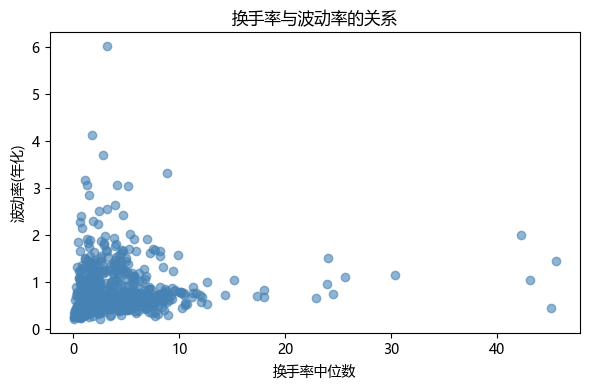

,ts_code_norm,波动率(年化),ts_code,trade_start_year,成交额中位数,成交量中位数,换手率中位数,低换手日比例,低成交额日比例,industry,market,list_year,覆盖天数
0,600768_SH,0.459612,600768.SH,2010,22053.1610,22341.01,1.7180,0.100028,0.100028,铝,主板,1996,5836
1,603276_SH,0.488141,603276.SH,2023,40796.2825,24648.18,3.9843,0.100733,0.100733,化工原料,主板,2023,824
2,688603_SH,0.771347,688603.SH,2023,54565.4590,8590.09,4.0551,0.101498,0.101498,化工原料,科创板,2023,901
3,300808_SZ,0.519180,300808.SZ,2019,35242.6960,19965.00,2.8607,0.100339,0.100339,家用电器,创业板,2019,2220
4,688737_SH,0.520526,688737.SH,2021,28107.2970,10643.38,1.8300,0.100295,0.100295,汽车配件,科创板,2021,1527


In [36]:
# 相关性：换手率与波动率

# 统一代码规范，避免 ts_code 合并失败
normalize = lambda s: s.replace('.', '_') if isinstance(s, str) else s
restore_dot = lambda s: s.replace('_', '.') if isinstance(s, str) else s

vol_records = []
for code, path in tqdm(daily_files_map.items(), desc='计算波动率'):
    df = load_parquet(path)
    if len(df) == 0 or 'close' not in df:
        continue
    df = df.sort_values('trade_date')
    log_ret = np.log(df['close']).diff().dropna()
    vol_ann = log_ret.std() * np.sqrt(252)
    vol_records.append({'ts_code_norm': normalize(code), '波动率(年化)': vol_ann})

df_vol = pd.DataFrame(vol_records)

# 用规范化字段与流动性表合并，避免点/下划线不一致
if 'ts_code_norm' not in df_liq:
    df_liq['ts_code_norm'] = df_liq['ts_code'].apply(normalize)

df_corr = df_vol.merge(df_liq, on='ts_code_norm', how='left')
df_corr = df_corr.dropna(subset=['波动率(年化)', '换手率中位数'])

if not df_corr.empty:
    corr_val = df_corr['波动率(年化)'].corr(df_corr['换手率中位数'])
    print(f"波动率 vs 换手率中位数 相关系数: {corr_val:.3f}")
    plt.figure(figsize=(6, 4))
    plt.scatter(df_corr['换手率中位数'], df_corr['波动率(年化)'], alpha=0.6, color='steelblue')
    plt.xlabel('换手率中位数')
    plt.ylabel('波动率(年化)')
    plt.title('换手率与波动率的关系')
    plt.tight_layout()
    plt.show()
else:
    print('df_corr 为空，可能是代码对不上的问题，请检查 ts_code 匹配')

df_corr.head()

In [37]:
# 分层相关性：按行业与市场分组的换手率-波动率相关
if df_corr.empty:
    print('df_corr 为空，跳过分层相关性')
else:
    # 行业分层（需足够样本）
    df_ind = df_corr.dropna(subset=['industry']).copy()
    grp_ind = (
        df_ind.groupby('industry')
        .apply(lambda g: pd.Series({
            '样本数': len(g),
            '相关系数': g['波动率(年化)'].corr(g['换手率中位数'])
        }))
        .reset_index()
    )
    grp_ind = grp_ind[grp_ind['样本数'] >= 15].sort_values('相关系数', ascending=False)
    print('行业分组相关（样本≥15）:')
    print(grp_ind.head(10))

    # 市场分层
    df_mkt = df_corr.dropna(subset=['market']).copy()
    grp_mkt = (
        df_mkt.groupby('market')
        .apply(lambda g: pd.Series({
            '样本数': len(g),
            '相关系数': g['波动率(年化)'].corr(g['换手率中位数'])
        }))
        .reset_index()
    )
    print('\n市场分组相关:')
    print(grp_mkt)


行业分组相关（样本≥15）:
   industry    样本数      相关系数
17     化学制药   55.0  0.640025
85       航空   29.0  0.565515
4       互联网   28.0  0.502891
1      专用机械  130.0  0.420908
93     运输设备   17.0  0.380679
24      半导体  115.0  0.350952
50     机械基件   63.0  0.348663
2       中成药   17.0  0.341399
34     广告包装   18.0  0.295487
90     软件服务  129.0  0.282334

市场分组相关:
  market    样本数      相关系数
0     主板  656.0  0.452042
1    创业板  546.0  0.466685
2    北交所  286.0  0.005697
3    科创板  511.0  0.478602


## 2.7A 价量分层与回归增强
- 分层相关：行业、市值分桶的换手率-波动率相关
- 横截面回归：波动率 ~ 换手率 + 市值 + 行业哑变量
- 时间演变：按年份的换手率-波动率相关

In [38]:
# 市值特征与分层相关（行业、市值分桶）
turnover_candidates = turnover_candidates if 'turnover_candidates' in locals() else ['turnover_rate', 'turnover_rate_f', 'turnover_rate5', 'turnover_rate20']

mktcap_records = []
for code, path in tqdm(daily_files_map.items(), desc='计算市值特征'):
    db_path = daily_basic_dir / f"{code}.parquet"
    if not db_path.exists():
        continue
    db = load_parquet(db_path)
    if len(db) == 0:
        continue
    db['trade_date'] = pd.to_datetime(db['trade_date'])
    med_total = pd.to_numeric(db['total_mv'], errors='coerce').median() if 'total_mv' in db else np.nan
    med_circ = pd.to_numeric(db['circ_mv'], errors='coerce').median() if 'circ_mv' in db else np.nan
    mktcap_records.append({'ts_code_norm': code, '总市值中位数': med_total, '流通市值中位数': med_circ})

df_mktcap = pd.DataFrame(mktcap_records)
df_corr_ext = df_corr.merge(df_mktcap, on='ts_code_norm', how='left')
df_corr_ext['市值(优先流通)'] = df_corr_ext['流通市值中位数'].combine_first(df_corr_ext['总市值中位数'])
df_corr_ext['log_mv'] = np.log(df_corr_ext['市值(优先流通)'])

if df_corr_ext['市值(优先流通)'].notna().sum() >= 30:
    try:
        df_corr_ext['size_bucket'] = pd.qcut(df_corr_ext['市值(优先流通)'], q=3, labels=['小', '中', '大'], duplicates='drop')
    except ValueError:
        df_corr_ext['size_bucket'] = pd.qcut(df_corr_ext['市值(优先流通)'].rank(method='first'), q=3, labels=['小', '中', '大'])
else:
    df_corr_ext['size_bucket'] = np.nan

print('全局相关:')
print(df_corr_ext[['波动率(年化)', '换手率中位数']].corr().iloc[0, 1])

if not df_corr_ext.empty:
    def _corr(g):
        return pd.Series({'样本数': len(g), '相关系数': g['波动率(年化)'].corr(g['换手率中位数'])})

    ind_corr = (
        df_corr_ext.dropna(subset=['industry'])
        .groupby('industry')
        .apply(_corr)
        .reset_index()
    )
    ind_corr = ind_corr[ind_corr['样本数'] >= 15].sort_values('相关系数', ascending=False)
    print('\n行业分层相关（样本≥15）:')
    print(ind_corr.head(10))

    size_corr = (
        df_corr_ext.dropna(subset=['size_bucket'])
        .groupby('size_bucket')
        .apply(_corr)
        .reset_index()
        .sort_values('size_bucket')
    )
    print('\n市值分桶相关:')
    print(size_corr)
else:
    print('df_corr_ext 为空，检查前置单元格是否执行')

计算市值特征: 100%|██████████| 2000/2000 [00:13<00:00, 146.07it/s]

全局相关:
0.21340452097078919

行业分层相关（样本≥15）:
   industry    样本数      相关系数
17     化学制药   55.0  0.640025
85       航空   29.0  0.565515
4       互联网   28.0  0.502891
1      专用机械  130.0  0.420908
93     运输设备   17.0  0.380679
24      半导体  115.0  0.350952
50     机械基件   63.0  0.348663
2       中成药   17.0  0.341399
34     广告包装   18.0  0.295487
90     软件服务  129.0  0.282334

市值分桶相关:
  size_bucket    样本数      相关系数
0           小  666.0  0.041905
1           中  667.0  0.287227
2           大  666.0  0.650590


In [39]:
# 横截面回归：波动率 ~ 换手率 + log(市值) + 行业哑变量
try:
    import statsmodels.api as sm
except Exception:
    sm = None

if sm is None:
    print('statsmodels 不可用，跳过回归')
else:
    df_reg = df_corr_ext.dropna(subset=['波动率(年化)', '换手率中位数', 'log_mv']).copy()
    # 确保数值型，去除非有限值
    for col in ['波动率(年化)', '换手率中位数', 'log_mv']:
        df_reg[col] = pd.to_numeric(df_reg[col], errors='coerce')
    df_reg = df_reg.replace([np.inf, -np.inf], np.nan).dropna(subset=['波动率(年化)', '换手率中位数', 'log_mv'])
    if df_reg.empty:
        print('可回归样本为空，检查市值/换手率数据')
    else:
        industry_dummies = pd.get_dummies(df_reg['industry'].fillna('未知'), prefix='ind', drop_first=True).astype(float)
        X = pd.concat([df_reg[['换手率中位数', 'log_mv']].astype(float), industry_dummies], axis=1)
        X = sm.add_constant(X, has_constant='add')
        y = df_reg['波动率(年化)'].astype(float)
        model = sm.OLS(y, X, missing='drop')
        res = model.fit(cov_type='HC3')
        coef_turn = res.params.get('换手率中位数', np.nan)
        t_turn = res.tvalues.get('换手率中位数', np.nan)
        p_turn = res.pvalues.get('换手率中位数', np.nan)
        coef_mv = res.params.get('log_mv', np.nan)
        t_mv = res.tvalues.get('log_mv', np.nan)
        p_mv = res.pvalues.get('log_mv', np.nan)
        print(f"样本数: {int(res.nobs)}, R2: {res.rsquared:.3f}, 调整R2: {res.rsquared_adj:.3f}")
        print(f"换手率系数: {coef_turn:.4f} (t={t_turn:.2f}, p={p_turn:.3f})")
        print(f"log(市值)系数: {coef_mv:.4f} (t={t_mv:.2f}, p={p_mv:.3f})")
        ind_effects = res.params[res.params.index.str.startswith('ind_')]
        ind_t = res.tvalues[ind_effects.index]
        ind_table = (
            pd.DataFrame({'coef': ind_effects, 't': ind_t})
            .assign(abs_t=lambda df: df['t'].abs())
            .sort_values('abs_t', ascending=False)
        )
        print('\n行业哑变量（按 |t| 排序前10）:')
        print(ind_table.head(10))

样本数: 1999, R2: 0.246, 调整R2: 0.203
换手率系数: 0.0095 (t=2.29, p=0.022)
log(市值)系数: -0.1187 (t=-12.93, p=0.000)

行业哑变量（按 |t| 排序前10）:
              coef         t     abs_t
ind_啤酒   -0.246093 -5.937267  5.937267
ind_服饰   -0.188113 -4.180665  4.180665
ind_染料涂料 -0.221303 -4.000417  4.000417
ind_石油贸易 -0.156525 -3.719399  3.719399
ind_乳制品  -0.181697 -3.253386  3.253386
ind_保险    0.245224  2.824787  2.824787
ind_百货   -0.144229 -2.802100  2.802100
ind_仓储物流 -0.125811 -2.686988  2.686988
ind_环境保护 -0.130558 -2.605021  2.605021
ind_文教休闲 -0.127477 -2.575224  2.575224


按年份计算波动率-换手:   0%|          | 0/2000 [00:00<?, ?it/s]

按年份计算波动率-换手: 100%|██████████| 2000/2000 [00:34<00:00, 57.20it/s]


年度换手率-波动率相关:
year
2010    0.293799
2011    0.260778
2012    0.422831
2013    0.579353
2014    0.404017
2015    0.434349
2016    0.473687
2017    0.618419
2018    0.112162
2019    0.676239
2020    0.177494
2021    0.376620
2022    0.159700
2023    0.672750
2024    0.608071
2025    0.591349
dtype: float64


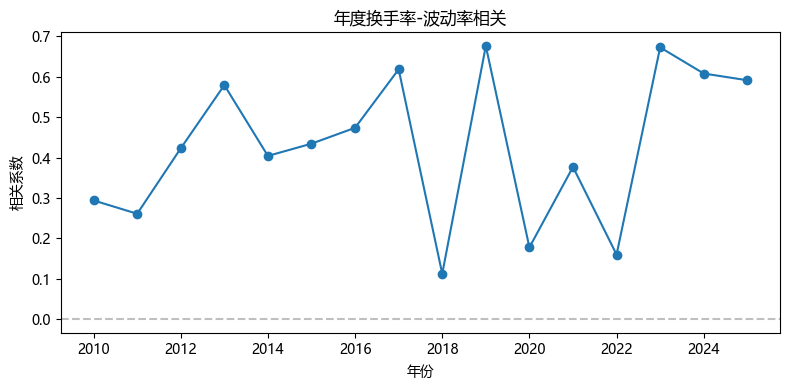

In [40]:
# 时间演变：按年份的换手率-波动率相关
turnover_candidates = turnover_candidates if 'turnover_candidates' in locals() else ['turnover_rate', 'turnover_rate_f', 'turnover_rate5', 'turnover_rate20']

yearly_records = []
for code, path in tqdm(daily_files_map.items(), desc='按年份计算波动率-换手'):
    df = load_parquet(path)
    if len(df) == 0 or 'close' not in df:
        continue
    df = df.sort_values('trade_date')
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df['year'] = df['trade_date'].dt.year
    df['log_ret'] = np.log(df['close']).diff()
    vol_year = df.groupby('year')['log_ret'].apply(lambda s: s.std() * np.sqrt(252))

    db_path = daily_basic_dir / f"{code}.parquet"
    turnover_year = pd.Series(dtype=float)
    if db_path.exists():
        db = load_parquet(db_path)
        if len(db):
            db['trade_date'] = pd.to_datetime(db['trade_date'])
            db['year'] = db['trade_date'].dt.year
            cols_lower = {c.lower(): c for c in db.columns}
            turnover_col = None
            for cand in turnover_candidates:
                if cand in cols_lower:
                    turnover_col = cols_lower[cand]
                    break
            if turnover_col:
                turnover_year = pd.to_numeric(db[turnover_col], errors='coerce').groupby(db['year']).median()

    common_years = vol_year.index.intersection(turnover_year.index)
    for y in common_years:
        yearly_records.append({
            'ts_code_norm': code,
            'year': int(y),
            '波动率(年化)': vol_year.loc[y],
            '换手率中位数': turnover_year.loc[y]
        })

df_yearly = pd.DataFrame(yearly_records).dropna(subset=['波动率(年化)', '换手率中位数'])
if not df_yearly.empty:
    yearly_corr = df_yearly.groupby('year').apply(lambda g: g['波动率(年化)'].corr(g['换手率中位数']))
    yearly_corr = yearly_corr.dropna()
    print('年度换手率-波动率相关:')
    print(yearly_corr)
    plt.figure(figsize=(8, 4))
    yearly_corr.plot(marker='o')
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title('年度换手率-波动率相关')
    plt.xlabel('年份')
    plt.ylabel('相关系数')
    plt.tight_layout()
    plt.show()
else:
    print('年度分组数据为空，可能 turnover 列缺失或 ts_code 对齐失败')

#### 2.7/2.7A 结果解读（基于当前运行）

- 横截面回归：样本约 1999；R²≈0.246（调整后 0.203）。换手率系数 +0.0095，t≈2.29，p≈0.022，正向且弱显著；log(市值) 系数 -0.1187，t≈-12.9，p≈0.000，显著负向（小票更高波动）。
- 行业哑变量：显著负向的行业（波动率低于基准）集中在啤酒、服饰、染料涂料、石油贸易、乳制品、百货、仓储物流、环保、文教休闲；正向较大的是保险。说明行业对波动率存在结构性差异，回归已部分捕捉。
- 年度相关（换手率 vs 波动率）：2010–2024 大多为正且中等偏强（约 0.15–0.68），偶有回落但未转负，近几年仍处较高水平（2023 反弹到 ~0.65，2024 ~0.59）。说明价量正相关在时间上较稳定，阶段性强弱波动。

#### 可得出的结论

- 截面层面：流动性（换手率）对波动率有稳定的正向影响，但边际效应不大；市值是更强的解释变量，体量越大波动越低。
- 行业差异：部分防御性/稳健消费类行业显著降低波动，金融子行业（保险）提高波动；做后续分析可分行业建模或在风险模型中单独约束。
- 时间维度：换手率-波动率相关在过去十多年持续为正，近期仍偏高，说明当前市场环境下“高换手=高波动”关系未减弱，需在策略或风控中持续关注。

## 2.8 过滤与标注
- 规则：缺口率>1%、核心字段空值率>1%、低换手日比例>30%
- 产出：需要清洗或重点关注的股票清单

**当前过滤标准（用于标记）**
- 缺口：近3年缺口率>1%（若无该列则用全周期缺口率>1%）
- 空值：核心字段空值率>1%
- 流动性：低流动性比例>30%，其中低流动性比例=max(低换手日比例, 低成交额日比例)
  - 低换手日比例：换手率<=10%分位的天数占比，需覆盖≥60个交易日
  - 低成交额日比例：成交额<=10%分位的天数占比，需覆盖≥60个交易日
- 采样规模：2000 只股票（分层抽样覆盖各市场）
- 参数：RECENT_YEARS=3, TURNOVER_LOW_Q=0.10, AMOUNT_LOW_Q=0.10, LOW_LIQ_THRESHOLD=0.30, LOW_LIQ_MIN_DAYS=60

## 2.8A 标记汇总与可用性评分
- 标记汇总：按市场/行业统计高缺口/高空值/低流动性标记占比，输出 Top 名单
- 可用性评分：基于缺口率、空值率、低流动性比例构建得分，排序找出质量较高子集

In [43]:
# 过滤与标注：高缺失/高缺口/低流动性股票清单
flags = df_daily_stats.copy()
# 兼容 df_liq 中可能存在的 ts_code_norm_x/ts_code_norm_y 命名
if 'ts_code_norm' not in df_liq.columns:
    if 'ts_code_norm_x' in df_liq.columns:
        df_liq['ts_code_norm'] = df_liq['ts_code_norm_x']
    elif 'ts_code_norm_y' in df_liq.columns:
        df_liq['ts_code_norm'] = df_liq['ts_code_norm_y']

merge_cols = [c for c in ['ts_code_norm', 'ts_code', '换手率中位数', '低换手日比例', '低成交额日比例'] if c in df_liq.columns]
flags = flags.merge(df_liq[merge_cols], on='ts_code_norm', how='left')
# 使用近3年缺口率优先，否则回退总缺口率
gap_col = '近3年缺口率' if '近3年缺口率' in flags.columns else '缺口率'
flags['缺口标记'] = flags[gap_col] > 1
flags['空值标记'] = flags['核心字段空值率'] > 1
# 低流动性标记：换手率或成交额任一低分位比例超过阈值
flags['低流动性比例'] = flags[['低换手日比例', '低成交额日比例']].max(axis=1)
flags['低流动性标记'] = flags['低流动性比例'] > LOW_LIQ_THRESHOLD
flagged = flags[(flags['缺口标记']) | (flags['空值标记']) | (flags['低流动性标记'])]

print(f"需要关注的股票数: {len(flagged)} (采样 {SAMPLE_N})，缺口字段: {gap_col}")
code_col = 'ts_code'
if code_col not in flagged.columns:
    if 'ts_code_x' in flagged.columns:
        flagged[code_col] = flagged['ts_code_x']
    elif 'ts_code_y' in flagged.columns:
        flagged[code_col] = flagged['ts_code_y']
    elif 'ts_code_norm' in flagged.columns:
        flagged[code_col] = flagged['ts_code_norm']

display_cols = [c for c in [code_col, 'market', 'industry', 'list_year', gap_col, '核心字段空值率', '低流动性比例', '低换手日比例', '低成交额日比例'] if c in flagged.columns]

# 导出清单
EXPORT_FLAGGED_PATH.parent.mkdir(parents=True, exist_ok=True)
flagged.sort_values([gap_col, '核心字段空值率', '低流动性比例'], ascending=False).to_csv(EXPORT_FLAGGED_PATH, index=False)
print(f"已导出: {EXPORT_FLAGGED_PATH}")

flagged[display_cols].head()

需要关注的股票数: 164 (采样 2000)，缺口字段: 近3年缺口率
已导出: g:\理财\Quant_A_share_LongTerm\reports\flagged_daily_quality.csv


,ts_code,market,industry,list_year,近3年缺口率,核心字段空值率,低流动性比例,低换手日比例,低成交额日比例
17,002128_SZ,主板,铝,2007,1.236264,0.0,0.100322,0.100322,0.100054
21,688585_SH,科创板,化工原料,2020,1.923077,0.0,0.100159,0.100159,0.100159
25,603922_SH,主板,汽车配件,2017,1.373626,0.0,0.100203,0.100203,0.100203
32,300765_SZ,创业板,食品,2019,1.373626,0.0,0.100369,0.100369,0.100369
34,920982_BJ,北交所,医疗保健,2023,18.543956,0.0,0.101180,0.101180,0.100625


In [44]:
# 标记汇总：按市场/行业占比与 Top 名单
if flagged.empty:
    print('flagged 为空，请先运行标记单元')
else:
    # 处理 ts_code 列名
    code_col = 'ts_code' if 'ts_code' in flagged.columns else ('ts_code_x' if 'ts_code_x' in flagged.columns else 'ts_code_norm')
    # 占比：市场 / 行业
    for grp_col, title in [('market', '市场'), ('industry', '行业')]:
        if grp_col not in flagged.columns:
            continue
        grp = flagged.groupby(grp_col).agg({'ts_code': 'count'}) if 'ts_code' in flagged.columns else flagged.groupby(grp_col).size().to_frame('ts_code')
        grp['占比(%)'] = grp['ts_code'] / len(flags) * 100
        grp = grp.sort_values('占比(%)', ascending=False)
        print(f"\n{title}标记占比 (Top 10):")
        print(grp.head(10))
    
    # Top 名单（按缺口率、空值率、低流动性比例排序）
    sort_cols = []
    for c in ['近3年缺口率', '缺口率']:
        if c in flagged.columns:
            sort_cols.append(c)
            break
    for c in ['核心字段空值率', '低流动性比例']:
        if c in flagged.columns:
            sort_cols.append(c)
    sort_cols = sort_cols if sort_cols else flagged.columns.tolist()
    top_list = flagged.sort_values(sort_cols, ascending=False).copy()
    display_cols = [c for c in [code_col, 'market', 'industry', 'list_year'] + sort_cols if c in top_list.columns]
    print('\n标记 Top 20（优先缺口/空值/低流动性高者）:')
    print(top_list[display_cols].head(20))


市场标记占比 (Top 10):
        ts_code  占比(%)
market                
北交所          81   4.05
主板           36   1.80
科创板          31   1.55
创业板          16   0.80

行业标记占比 (Top 10):
          ts_code  占比(%)
industry                
半导体            17   0.85
汽车配件           13   0.65
化工原料           11   0.55
专用机械            9   0.45
化学制药            7   0.35
通信设备            7   0.35
元器件             7   0.35
电气设备            7   0.35
软件服务            7   0.35
食品              6   0.30

标记 Top 20（优先缺口/空值/低流动性高者）:
        ts_code market industry  list_year     近3年缺口率  核心字段空值率    低流动性比例
1338  920931_BJ    北交所     化工机械       2024  42.170330      0.0  0.102138
1114  920123_BJ    北交所     日用化工       2024  41.346154      0.0  0.100703
1040  920438_BJ    北交所      元器件       2024  41.071429      0.0  0.100000
314   920706_BJ    北交所     工程机械       2024  39.560440      0.0  0.101580
1988  920656_BJ    北交所     化学制药       2024  36.950549      0.0  0.100218
1795  920496_BJ    北交所     电气设备       2024  35.851648      0

In [42]:
# 标记结果诊断
gap_col = '近3年缺口率' if '近3年缺口率' in flags.columns else '缺口率'
reason_counts = {
    '缺口标记数': int(flagged['缺口标记'].sum()),
    '空值标记数': int(flagged['空值标记'].sum()),
    '低流动性标记数': int(flagged['低流动性标记'].sum())
}
print('标记数量分解:', reason_counts)
print(f'当前缺口字段: {gap_col}')
print('\n低流动性比例分位数:')
print(flags['低流动性比例'].describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))
print('\n缺口分位数:')
print(flags[gap_col].describe([0.5, 0.75, 0.9, 0.95, 0.99]))
print('\n核心字段空值率分位数:')
print(flags['核心字段空值率'].describe([0.5, 0.75, 0.9, 0.95, 0.99]))
if {'低换手日比例','低成交额日比例'}.issubset(flags.columns):
    print('\n低换手/低成交额日比例概览:')
    print(flags[['低换手日比例','低成交额日比例']].describe([0.1,0.25,0.5,0.75,0.9,0.95]))

标记数量分解: {'缺口标记数': 164, '空值标记数': 0, '低流动性标记数': 0}
当前缺口字段: 近3年缺口率

低流动性比例分位数:
count    1978.000000
mean        0.100504
std         0.000945
min         0.100000
10%         0.100027
25%         0.100118
50%         0.100275
75%         0.100629
90%         0.101010
95%         0.101366
max         0.114754
Name: 低流动性比例, dtype: float64

缺口分位数:
count    2000.000000
mean        0.776720
std         4.049753
min         0.000000
50%         0.000000
75%         0.000000
90%         0.686813
95%         1.373626
99%        25.418956
max        42.170330
Name: 近3年缺口率, dtype: float64

核心字段空值率分位数:
count    2000.0
mean        0.0
std         0.0
min         0.0
50%         0.0
75%         0.0
90%         0.0
95%         0.0
99%         0.0
max         0.0
Name: 核心字段空值率, dtype: float64

低换手/低成交额日比例概览:
            低换手日比例      低成交额日比例
count  1978.000000  1978.000000
mean      0.100486     0.100442
std       0.000941     0.000930
min       0.100000     0.100000
10%       0.100026     0.100026
25%   

In [46]:
# 数据可用性评分
if 'flagged' not in locals() or flags.empty:
    print('flags/flagged 不存在，请先运行标记单元')
else:
    df_score = flags.copy()
    gap_col = '近3年缺口率' if '近3年缺口率' in df_score.columns else '缺口率'
    # 归一化得分（越低越好）：缺口、空值、低流动性
    components = {}
    for c in [gap_col, '核心字段空值率', '低流动性比例']:
        if c in df_score.columns:
            s = df_score[c]
            # Min-max 归一化到 [0,1]，防止分母为0
            if s.max() == s.min():
                comp = pd.Series(0, index=s.index)
            else:
                comp = (s - s.min()) / (s.max() - s.min())
            components[c] = comp
    if not components:
        print('缺少评分所需的列')
    else:
        comp_df = pd.DataFrame(components)
        df_score['可用性得分'] = 1 - comp_df.mean(axis=1)  # 越高越好
        df_score = df_score.sort_values('可用性得分', ascending=False)
        display_cols = [c for c in ['ts_code', 'market', 'industry', 'list_year', gap_col, '核心字段空值率', '低流动性比例', '可用性得分'] if c in df_score.columns]
        print('\n可用性前 20:')
        print(df_score[display_cols].head(20))
        print('\n可用性分位:')
        print(df_score['可用性得分'].describe([0.1,0.25,0.5,0.75,0.9,0.95]))



可用性前 20:
     market industry  list_year  近3年缺口率  核心字段空值率  低流动性比例  可用性得分
29       主板     家用电器       2018     0.0      0.0     0.1    1.0
1952     主板     农用机械       1994     0.0      0.0     0.1    1.0
526     创业板     通信设备       2011     0.0      0.0     0.1    1.0
519     北交所     专用机械       2025     0.0      0.0     NaN    1.0
486     创业板      元器件       2019     0.0      0.0     0.1    1.0
1933    创业板     IT设备       2021     0.0      0.0     0.1    1.0
516     创业板     汽车配件       2023     0.0      0.0     0.1    1.0
984      主板     多元金融       2012     0.0      0.0     0.1    1.0
77      创业板      元器件       2021     0.0      0.0     0.1    1.0
76      科创板     环境保护       2020     0.0      0.0     0.1    1.0
1548    科创板     医疗保健       2022     0.0      0.0     0.1    1.0
469     创业板     电器仪表       2016     0.0      0.0     0.1    1.0
1489    创业板     其他建材       2021     0.0      0.0     0.1    1.0
1050    创业板     电气设备       2017     0.0      0.0     0.1    1.0
976      主板     生物制药       199